In [15]:
# ============================================================================
# CELL 1: Setup & Install
# ============================================================================

!pip install kaggle xgboost gradio -q

import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
# Setup Kaggle API (upload kaggle.json first)
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!chmod 600 /content/kaggle.json

# Download dataset
!kaggle datasets download -d nelgiriyewithana/credit-card-fraud-detection-dataset-2023 -q
!unzip -o credit-card-fraud-detection-dataset-2023.zip

!ls

print("Setup complete!")

Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023
License(s): other
Archive:  credit-card-fraud-detection-dataset-2023.zip
  inflating: creditcard_2023.csv     
creditcard_2023.csv			      random_forest_model.joblib
credit-card-fraud-detection-dataset-2023.zip  sample_data
kaggle.json				      scaler.joblib
logistic_model.joblib
Setup complete!


Dataset shape: (568630, 31)

Class distribution:
Class
0    284315
1    284315
Name: count, dtype: int64

Fraud percentage: 50.000%
   id        V1        V2        V3        V4        V5        V6        V7  \
0   0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1   1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2   2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3   3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4   4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.130006  0.727159  ... -0.110552  0.217606 -0.134794  0.165959  0.126280   
1 -0.133118  0.347452  ... -0.194936 -0.605761  0.079469 -0.577395  0.190090   
2 -0.095576 -0.261297  ... -0.005020  0.702906  0.945045 -1.154666 -0.605564   
3 -0.065130 -0.205698  ... -0.146927 -0.038212 -0.214048 -1.893131  1.003

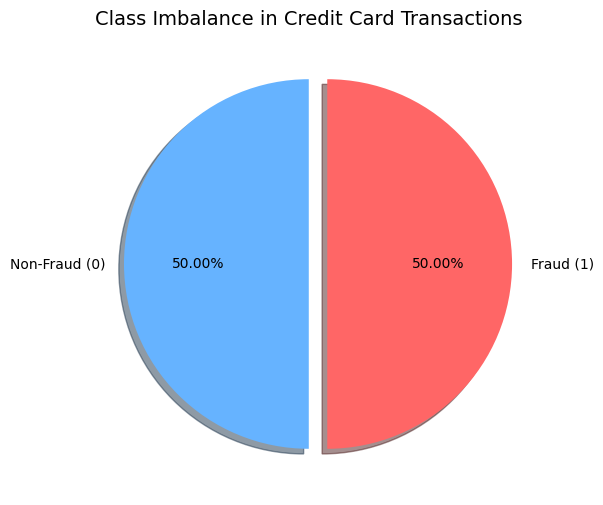


 Data split complete!
Train: (454904, 30), Test: (113726, 30)


In [16]:
# ============================================================================
# CELL 2: Load & Split Data
# ============================================================================

# Load dataset
df = pd.read_csv("/content/creditcard_2023.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:\n{df['Class'].value_counts()}")
print(f"\nFraud percentage: {df['Class'].sum()/len(df)*100:.3f}%")

print(df.head())
# Visualize Data Imbalance

plt.figure(figsize=(6,6))
labels = ['Non-Fraud (0)', 'Fraud (1)']
sizes = df['Class'].value_counts()
colors = ['#66b3ff', '#ff6666']
explode = (0, 0.1)  # explode the fraud slice for emphasis

plt.pie(
    sizes,
    labels=labels,
    autopct='%1.2f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=True
)

plt.title("Class Imbalance in Credit Card Transactions", fontsize=14)
plt.show()

# Split data
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\n Data split complete!")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

In [17]:
# ============================================================================
# CELL 3: Train TWO Models (Logistic Regression & Random Forest)
# ============================================================================

# Scale features
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "="*70)
print(" TRAINING TWO MODELS")
print("="*70)

# Dictionary to store models and their performance
models = {}
results = {}

# -------------------------
# MODEL 1: Logistic Regression
# -------------------------
print("\n1 Training Logistic Regression...")
start_time = time.time()

logistic = LogisticRegression(
    max_iter=1000,           # Maximum iterations for convergence
    random_state=42,
    n_jobs=-1,               # Use all CPU cores
    class_weight='balanced'  # Handle imbalanced data
)
logistic.fit(X_train_scaled, y_train)

train_time_lr = time.time() - start_time
models['Logistic Regression'] = logistic
print(f"    Trained in {train_time_lr:.2f} seconds")

# -------------------------
# MODEL 2: Random Forest
# -------------------------
print("\n2 Training Random Forest...")
start_time = time.time()

rf = RandomForestClassifier(
    n_estimators=100,        # Number of trees
    max_depth=10,            # Max depth of each tree
    min_samples_split=10,    # Min samples to split a node
    min_samples_leaf=5,      # Min samples in leaf node
    random_state=42,
    n_jobs=-1,               # Use all CPU cores
    class_weight='balanced'  # Handle imbalanced data
)
rf.fit(X_train_scaled, y_train)

train_time_rf = time.time() - start_time
models['Random Forest'] = rf
print(f"    Trained in {train_time_rf:.2f} seconds")

# Save all models
joblib.dump(logistic, 'logistic_model.joblib')
joblib.dump(rf, 'random_forest_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

print("\n All models trained and saved!")
print(f"\n Training Times:")
print(f"   Logistic Regression: {train_time_lr:.2f}s")
print(f"   Random Forest: {train_time_rf:.2f}s")


Scaling features...

 TRAINING TWO MODELS

1 Training Logistic Regression...
    Trained in 4.38 seconds

2 Training Random Forest...
    Trained in 218.85 seconds

 All models trained and saved!

 Training Times:
   Logistic Regression: 4.38s
   Random Forest: 218.85s


In [18]:
# ============================================================================
# CELL 4: Evaluate & Compare Models + Testing
# ============================================================================

print("\n" + "="*70)
print(" MODEL COMPARISON ON TEST SET")
print("="*70)

comparison_results = []

for model_name, model in models.items():
    print(f"\n{'='*70}")
    print(f" {model_name.upper()}")
    print(f"{'='*70}")

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Classification report
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"True Negatives:  {cm[0][0]:,}")
    print(f"False Positives: {cm[0][1]:,}")
    print(f"False Negatives: {cm[1][0]:,}")
    print(f"True Positives:  {cm[1][1]:,}")

    # Store results
    comparison_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'AUC-ROC': auc_score,
        'True Positives': cm[1][1],
        'False Negatives': cm[1][0],
        'False Positives': cm[0][1]
    })

# Summary comparison
print("\n" + "="*70)
print(" OVERALL COMPARISON")
print("="*70)
comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string(index=False))

# Find best model
best_model_idx = comparison_df['AUC-ROC'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\n Best Model: {best_model_name} (Highest AUC-ROC: {comparison_df.loc[best_model_idx, 'AUC-ROC']:.4f})")

# -------------------------
# Test on 20 Random Transactions
# -------------------------
print("\n" + "="*70)
print(" TESTING 20 RANDOM TRANSACTIONS FROM TEST SET")
print("="*70)

# Get 10 normal and 10 fraud transactions
test_df = pd.concat([X_test, y_test], axis=1)
normal_samples = test_df[test_df['Class'] == 0].sample(10, random_state=42)
fraud_samples = test_df[test_df['Class'] == 1].sample(10, random_state=42)
test_20 = pd.concat([normal_samples, fraud_samples]).sample(frac=1, random_state=42)

for idx, (i, row) in enumerate(test_20.iterrows(), 1):
    X_input = row.drop('Class').values.reshape(1, -1)
    X_scaled = scaler.transform(X_input)
    actual = row['Class']

    print(f"\n{'─'*70}")

    #  Safe print — works even if “Time” column doesn’t exist
    if 'Time' in row:
        print(f"Transaction #{idx} | Amount: ${row['Amount']:.2f} | Time: {row['Time']:.0f}s")
    elif 'id' in row:
        print(f"Transaction #{idx} | ID: {row['id']} | Amount: ${row['Amount']:.2f}")
    else:
        print(f"Transaction #{idx} | Amount: ${row['Amount']:.2f}")

    print(f"Actual: {' FRAUD' if actual == 1 else ' NORMAL'}")
    print(f"{'─'*70}")

    # Test with both models
    for model_name, model in models.items():
        prob = model.predict_proba(X_scaled)[0][1]
        pred = model.predict(X_scaled)[0]

        # Determine risk level
        if prob > 0.7:
            risk = "HIGH"
            emoji = "!!!"
        elif prob > 0.3:
            risk = "MEDIUM"
            emoji = "!"
        else:
            risk = "LOW"
            emoji = ":)"

        # Status
        status = "✓" if pred == actual else "✗"

        print(f"   {model_name:20s} | {emoji} {risk:6s} | Prob: {prob*100:5.2f}% | "
              f"Pred: {'FRAUD' if pred == 1 else 'NORMAL':5s} | {status}")

print("\n Evaluation complete!")


 MODEL COMPARISON ON TEST SET

 LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0     0.9976    0.9990    0.9983     56863
           1     0.9990    0.9976    0.9983     56863

    accuracy                         0.9983    113726
   macro avg     0.9983    0.9983    0.9983    113726
weighted avg     0.9983    0.9983    0.9983    113726


Confusion Matrix:
True Negatives:  56,805
False Positives: 58
False Negatives: 137
True Positives:  56,726

 RANDOM FOREST
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     56863
           1     0.9998    0.9997    0.9998     56863

    accuracy                         0.9998    113726
   macro avg     0.9998    0.9998    0.9998    113726
weighted avg     0.9998    0.9998    0.9998    113726


Confusion Matrix:
True Negatives:  56,852
False Positives: 11
False Negatives: 16
True Positives:  56,847

 OVERALL COMPARISON
              Model  Accuracy  AUC-ROC  T

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


   Random Forest        | :) LOW    | Prob:  0.26% | Pred: NORMAL | ✓

──────────────────────────────────────────────────────────────────────
Transaction #5 | ID: 153894.0 | Amount: $8911.85
Actual:  NORMAL
──────────────────────────────────────────────────────────────────────
   Logistic Regression  | :) LOW    | Prob:  0.05% | Pred: NORMAL | ✓
   Random Forest        | :) LOW    | Prob:  0.53% | Pred: NORMAL | ✓

──────────────────────────────────────────────────────────────────────
Transaction #6 | ID: 114415.0 | Amount: $16713.68
Actual:  NORMAL
──────────────────────────────────────────────────────────────────────
   Logistic Regression  | :) LOW    | Prob:  0.00% | Pred: NORMAL | ✓
   Random Forest        | :) LOW    | Prob:  0.29% | Pred: NORMAL | ✓

──────────────────────────────────────────────────────────────────────
Transaction #7 | ID: 465370.0 | Amount: $23786.10
Actual:  FRAUD
──────────────────────────────────────────────────────────────────────
   Logistic Regression  |

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


   Random Forest        | !!! HIGH   | Prob: 97.06% | Pred: FRAUD | ✓

──────────────────────────────────────────────────────────────────────
Transaction #10 | ID: 452731.0 | Amount: $9742.45
Actual:  FRAUD
──────────────────────────────────────────────────────────────────────
   Logistic Regression  | !!! HIGH   | Prob: 100.00% | Pred: FRAUD | ✓
   Random Forest        | !!! HIGH   | Prob: 99.99% | Pred: FRAUD | ✓

──────────────────────────────────────────────────────────────────────
Transaction #11 | ID: 468308.0 | Amount: $19757.42
Actual:  FRAUD
──────────────────────────────────────────────────────────────────────
   Logistic Regression  | !!! HIGH   | Prob: 100.00% | Pred: FRAUD | ✓
   Random Forest        | !!! HIGH   | Prob: 99.99% | Pred: FRAUD | ✓

──────────────────────────────────────────────────────────────────────
Transaction #12 | ID: 34710.0 | Amount: $2972.09
Actual:  NORMAL
──────────────────────────────────────────────────────────────────────
   Logistic Regression 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


   Random Forest        | !!! HIGH   | Prob: 100.00% | Pred: FRAUD | ✓

──────────────────────────────────────────────────────────────────────
Transaction #15 | ID: 41715.0 | Amount: $11209.85
Actual:  NORMAL
──────────────────────────────────────────────────────────────────────
   Logistic Regression  | :) LOW    | Prob:  0.00% | Pred: NORMAL | ✓
   Random Forest        | :) LOW    | Prob:  0.36% | Pred: NORMAL | ✓

──────────────────────────────────────────────────────────────────────
Transaction #16 | ID: 505025.0 | Amount: $19020.42
Actual:  FRAUD
──────────────────────────────────────────────────────────────────────
   Logistic Regression  | !!! HIGH   | Prob: 100.00% | Pred: FRAUD | ✓
   Random Forest        | !!! HIGH   | Prob: 100.00% | Pred: FRAUD | ✓

──────────────────────────────────────────────────────────────────────
Transaction #17 | ID: 12041.0 | Amount: $8305.57
Actual:  NORMAL
──────────────────────────────────────────────────────────────────────
   Logistic Regressio

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


   Random Forest        | !!! HIGH   | Prob: 99.99% | Pred: FRAUD | ✓

──────────────────────────────────────────────────────────────────────
Transaction #20 | ID: 56332.0 | Amount: $12215.73
Actual:  NORMAL
──────────────────────────────────────────────────────────────────────
   Logistic Regression  | :) LOW    | Prob:  0.00% | Pred: NORMAL | ✓
   Random Forest        | :) LOW    | Prob:  0.38% | Pred: NORMAL | ✓

 Evaluation complete!


In [19]:
# ============================================================================
# INTERACTIVE FRAUD DETECTION APP — User Inputs Amount, Clean Output
# ============================================================================

import gradio as gr
import numpy as np
import pandas as pd
import joblib
from datetime import datetime

# Load models
logistic_clf = joblib.load('logistic_model.joblib')
rf_clf = joblib.load('random_forest_model.joblib')
scaler = joblib.load('scaler.joblib')

# Load dataset for random sampling
df = pd.read_csv("/content/creditcard_2023.csv")
fraud_samples = df[df['Class'] == 1]
normal_samples = df[df['Class'] == 0]

def generate_and_predict(user_amount):

    # ----------------------------
    # 1. Pick a real transaction
    # ----------------------------
    # Use realistic distribution:
    # 80% → normal
    # 20% → fraud
    if np.random.random() < 0.2:
        sample = fraud_samples.sample(1).iloc[0]
        base_pattern = "Fraud-like Pattern"
    else:
        sample = normal_samples.sample(1).iloc[0]
        base_pattern = "Normal Pattern"

    # ----------------------------
    # 2. Replace ONLY the Amount
    # ----------------------------
    user_amount = float(user_amount)
    sample['Amount'] = user_amount

    # ----------------------------
    # 3. Prepare input
    # ----------------------------
    X_input = sample.drop('Class').values.reshape(1, -1)
    X_scaled = scaler.transform(X_input)

    # ----------------------------
    # 4. Model predictions
    # ----------------------------
    model_outputs = {}
    for name, model in {
        "Logistic Regression": logistic_clf,
        "Random Forest": rf_clf
    }.items():
        prob = model.predict_proba(X_scaled)[0][1]
        pred = model.predict(X_scaled)[0]

        # ML model risk
        if prob > 0.7:
            ml_risk = "HIGH"
        elif prob > 0.3:
            ml_risk = "MEDIUM"
        else:
            ml_risk = "LOW"

        model_outputs[name] = {
            "prob": prob,
            "pred": pred,
            "ml_risk": ml_risk
        }

    # ----------------------------
    # 5. RULE-BASED OVERRIDES
    # ----------------------------
    # Default override = None (use ML)
    override_risk = None

    if user_amount <= 10:
        override_risk = "LOW"           # very small amount → low risk
    elif user_amount >= 50000:
        override_risk = "MEDIUM"        # large amount → suspicious
    elif user_amount >= 200000:
        override_risk = "HIGH"          # very large → high risk

    # ----------------------------
    # 6. Combine ML + Override
    # ----------------------------
    # risk priority order:
    priority = {"LOW": 1, "MEDIUM": 2, "HIGH": 3}

    final_results = {}
    for name, data in model_outputs.items():
        ml_risk = data["ml_risk"]

        if override_risk is None:
            final_risk = ml_risk
        else:
            # take the higher risk between ML and RULE
            final_risk = (
                override_risk
                if priority[override_risk] > priority[ml_risk]
                else ml_risk
            )

        final_results[name] = {
            "risk": final_risk,
            "prob": data["prob"],
            "pred": data["pred"]
        }

    # ----------------------------
    # 7. Build Output Text
    # ----------------------------
    result_md = f"""
## Transaction Summary
- **Amount Entered:** ₹{user_amount:,.2f}
- **Analyzed Pattern:** {base_pattern}
"""

    if override_risk:
        result_md += f"- **According To Amount Entered:** {override_risk} \n"

    result_md += "\n---\n## Model Predictions\n"

    for name, data in final_results.items():
        result_md += f"""
### {name}
- **Final Risk:** {data['risk']}
- **ML Probability of Fraud:** {data['prob']*100:.2f}%
- **Model Classified:** {"FRAUD" if data['pred']==1 else "LEGITIMATE"}
---
"""

    # CONSENSUS
    avg_prob = np.mean([m["prob"] for m in final_results.values()])

    if avg_prob > 0.7:
        consensus = "HIGH"
    elif avg_prob > 0.3:
        consensus = "MEDIUM"
    else:
        consensus = "LOW"

    # Apply override to consensus
    if override_risk and priority[override_risk] > priority[consensus]:
        consensus = override_risk

    result_md += f"""
## Final Consensus
- **Consensus Risk:** {consensus}
- **Average Fraud Probability:** {avg_prob*100:.2f}%
"""

    return result_md



# ============================================================================
# Gradio App
# ============================================================================
with gr.Blocks(theme=gr.themes.Soft(), title="Fraud Detection") as app:

    gr.Markdown("""
    #  Credit Card Fraud Detection System
    ### Multi-Model AI-Powered Risk Analysis

    Enter a **transaction amount** and let the system analyze the fraud risk using two models:
    - Logistic Regression
    - Random Forest
    """)

    user_amount = gr.Number(
        label="Enter Transaction Amount (₹ or $)",
        value=100.0,
        minimum=0,
        step=10
    )

    analyze_btn = gr.Button(" Analyze Transaction", variant="primary", size="lg")
    output = gr.Markdown(label="Analysis Results")

    analyze_btn.click(fn=generate_and_predict, inputs=user_amount, outputs=output)

    gr.Markdown("""
    ---
    ###  How It Works
    1. You enter an amount
    2. The system generates a realistic transaction profile
    3. Both models analyze it
    4. A consensus risk level is shown
    ---
    """)

print("\n" + "=" * 70)
print(" Launching Interactive Fraud Detection App...")
print("=" * 70)

app.launch(share=True, debug=False)



 Launching Interactive Fraud Detection App...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d82c9946833afb9e9a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
